In [117]:
import csv
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from pylab import *
#import fits
import copy

import sklearn
import sklearn.mixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
#import umap
from sklearn.mixture import GaussianMixture
sns.set_palette(sns.color_palette("hls", 20))

In [26]:
roi_df = pd.read_csv("C:/Users/mclaughlin.aj/Documents/AM_ANALYSIS/CellProfiler_190212/BM_AM_180808_190312_Results.csv")
roi_df.head(5)

,image,ind cell index,total cell index,Area,Circ.,AR,Round,Solidity,Pax6_mean,Islet1_mean,...,SCGN_median,Kv2.2_median,DAPI3_median,CAVIII_median,Rec_median,DAPI4_median,Calb_median,PKC_median,Parv_median,DAPI5_median
0,21_s1m1,0,0,0.047,0.458,1.551,0.645,0.795,1093.606,1237.738,...,545,2559,432,2216,14732,363,1005,911,554,383
1,21_s1m1,1,1,0.032,0.868,1.462,0.684,0.916,389.737,1787.737,...,505,2325,1421,2063,3089,566,625,901,485,2563
2,21_s1m1,2,2,0.037,0.871,1.156,0.865,0.912,436.575,1095.472,...,1934,2564,2181,2039,2349,578,618,664,304,3695
3,21_s1m1,3,3,0.044,0.709,1.674,0.597,0.879,576.280,1651.413,...,348,2414,3377,1760,1433,799,676,729,247,6672
4,21_s1m1,4,4,0.037,0.658,1.233,0.811,0.787,462.293,1785.806,...,435,2516,1796,1804,1312,432,618,745,275,2477


In [29]:
#gets rid of all cells which don't have 0 values (off target ROIS)
#DAPI_mean won't have any, as ROIs are generated from this file. But all other imaging rounds will.
roi_df = roi_df[roi_df['CD15_mean'] > 0]
roi_df = roi_df[roi_df['GLT-1_mean'] > 0]
roi_df = roi_df[roi_df['Cav3.1_mean'] > 0]
roi_df = roi_df[roi_df['CABP5_mean'] > 0]
roi_df = roi_df[roi_df['SSCGN_mean'] > 0]
roi_df = roi_df[roi_df['Kv2.2_mean'] > 0]
roi_df = roi_df[roi_df['CAVIII_mean'] > 0]
roi_df = roi_df[roi_df['Rec_mean'] > 0]
roi_df = roi_df[roi_df['Calb_mean'] > 0]
roi_df = roi_df[roi_df['PKC_mean'] > 0]
roi_df = roi_df[roi_df['Parv_mean'] > 0]
roi_df = roi_df[roi_df['DAPI5_mean'] > 0]

In [30]:
#function to determine threshold for 99% normalization
def determineThresholds(col, table, cutoff=0.01): #change bins?
    '''Determines the thresholds for the column of the table with the given cutoff.
    Returns the left x and right x that at the cutoff value. For example, with a cutoff of
    0.01, this fn will return the left x and right x that keeps 1% of the mass on the left
    and 1% of the mass on the right, respectively.'''
    assert(cutoff > 0 and cutoff < 1)
    nparr = np.asarray(table[col].tolist())
    y,x,_=hist(nparr,1000,alpha=.3,label='data')
    x=(x[1:]+x[:-1])/2
    sum = 0
    for ycord in y:
        sum += ycord
    left = sum * cutoff
    right = sum * (1 - cutoff)
    sum = 0
    leftx = 0
    rightx = 0
    for xcord, ycord in zip(x,y):
        sum += ycord
        if (left < sum and leftx == 0):
            leftx = xcord
        if (right < sum and rightx == 0):
            rightx = xcord
            break
    return leftx, rightx

(181.706032, 8363.116336)

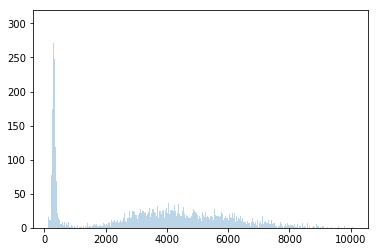

In [31]:
#example threshold calculation for DAPI channel
determineThresholds("DAPI_mean", roi_df)

In [32]:
#calculates thresholds for all columns, set events above and below thresholds to 1 and 0 respectively

def normalize(col, table, cutoff=0.01):
    '''Determines thresholds using the determineThresholds fn. For all numbers
    greater than 1, they are made 1. For all numbers less than 0, they are made 0.
    A new col named normalized + colname is created in the table.'''
    leftx, rightx = determineThresholds(col, table, cutoff=0.01)
    def new(signal):
        normsignal = (signal - leftx) / (rightx - leftx)
        if (normsignal > 1):
            return 1
        elif (normsignal < 0):
            return 0
        else:
            return normsignal
    return table[col].apply(new)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020119750C50>]],
      dtype=object)

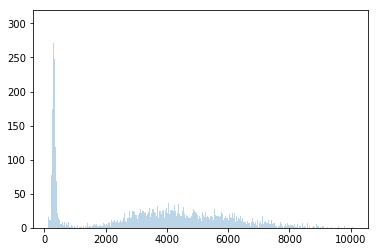

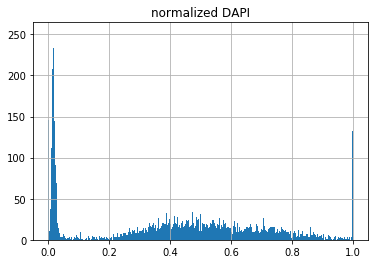

In [33]:
#Look at DAPI histogram, establish cutoff to remove DAPI-negative ROIs
roi_df["normalized DAPI"] = normalize("DAPI_mean", roi_df)
roi_df.hist(column="normalized DAPI", bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002016D1BF550>]],
      dtype=object)

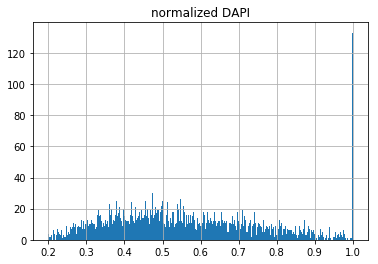

In [34]:
dapi_rm_roi_df = roi_df[roi_df['normalized DAPI'] > 0.2]
dapi_rm_roi_df.hist(column="normalized DAPI", bins=1000)

Passed  image 
Passed  ind cell index
Passed  total cell index
Normalizing   Area
Normalizing   Circ.
Normalizing   AR
Normalizing   Round
Normalizing   Solidity
Normalizing   Pax6_mean
Normalizing   Islet1_mean
Normalizing   TARPg3_mean
Normalizing   DAPI_mean
Normalizing   CD15_mean
Normalizing   GLT-1_mean
Normalizing   Cav3.1_mean
Normalizing   DAPI2_mean
Normalizing   CABP5_mean
Normalizing   SSCGN_mean
Normalizing   Kv2.2_mean
Normalizing   DAPI3_mean
Normalizing   CAVIII_mean
Normalizing   Rec_mean
Normalizing   DAPI4_mean
Normalizing   Calb_mean
Normalizing   PKC_mean
Normalizing   Parv_mean
Normalizing   DAPI5_mean
Normalizing   Pax6_stddev
Normalizing   Islet1_stddev
Normalizing   Tarpg3_stddev
Normalizing   DAPI_stddev
Normalizing   CD15_stddev
Normalizing   GLT-1_stddev
Normalizing   Cav3.1_stddev
Normalizing   DAPI2_stddev
Normalizing   CABP5_stddev
Normalizing   SCGN_stddev
Normalizing   Kv2.2_stddev
Normalizing   DAPI3_stddev
Normalizing   CAVIII_stddev
Normalizing   Rec

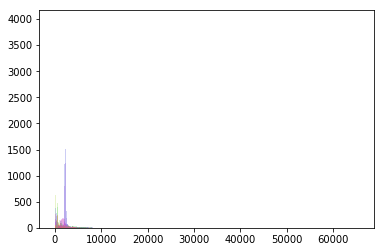

In [56]:
#runs 99% normalization on all channels, saves data in new columns of the same dataframe
rm_roi_df = dapi_rm_roi_df.copy()
for col in list(dapi_rm_roi_df):
    if col.startswith("normalized") or col.startswith("image") or col.startswith("ind cell index") or col.startswith("total") or (dapi_rm_roi_df[col]).isna().any():
        print("Passed ", col)
        continue
    print("Normalizing  ", col)
    rm_roi_df["normalized " + col] = normalize(col, dapi_rm_roi_df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002015BB00198>]],
      dtype=object)

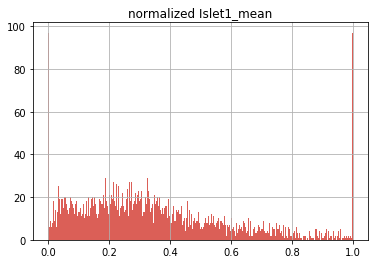

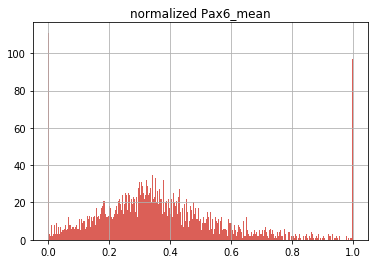

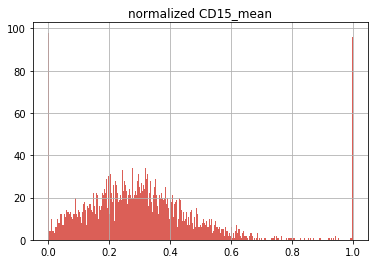

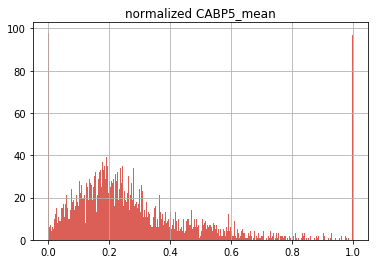

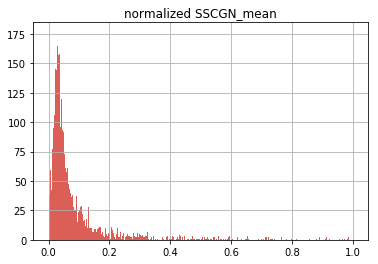

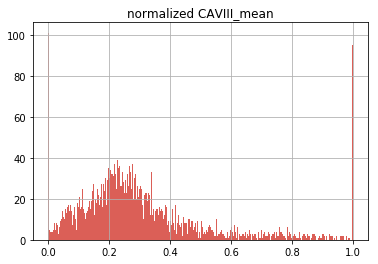

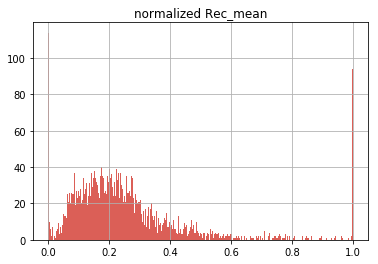

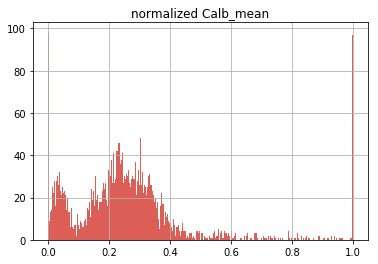

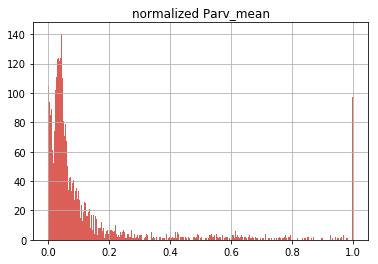

In [57]:
rm_roi_df.hist(column="normalized Islet1_mean", bins=1000)
rm_roi_df.hist(column="normalized Pax6_mean", bins=1000)
rm_roi_df.hist(column="normalized CD15_mean", bins=1000)
rm_roi_df.hist(column="normalized CABP5_mean", bins=1000)
rm_roi_df.hist(column="normalized SSCGN_mean", bins=1000)
rm_roi_df.hist(column="normalized CAVIII_mean", bins=1000)
rm_roi_df.hist(column="normalized Rec_mean", bins=1000)
rm_roi_df.hist(column="normalized Calb_mean", bins=1000)
rm_roi_df.hist(column="normalized Parv_mean", bins=1000)

In [58]:
#STARTING CLUSTERING ON NORMALIZED DATA

#drop columns we don't want to normalize
new_data=rm_roi_df
new_data=new_data.drop(["normalized DAPI_mean", "normalized TARPg3_mean", "normalized GLT-1_mean", "normalized Cav3.1_mean", "normalized DAPI2_mean", "normalized Kv2.2_mean", "normalized DAPI3_mean", "normalized DAPI4_mean", "normalized PKC_mean", "normalized DAPI5_mean"], axis=1)
new_data=new_data.drop(["normalized DAPI_stddev", "normalized Tarpg3_stddev", "normalized GLT-1_stddev", "normalized Cav3.1_stddev", "normalized DAPI2_stddev", "normalized Kv2.2_stddev", "normalized DAPI3_stddev", "normalized DAPI4_stddev", "normalized PKC_stddev", "normalized DAPI5_stddev"], axis=1)
new_data=new_data.drop(["normalized DAPI_median", "normalized TARPg3_median", "normalized GLT-1_median", "normalized Cav3.1_median", "normalized DAPI2_median", "normalized Kv2.2_median", "normalized DAPI3_median", "normalized DAPI4_median", "normalized PKC_median", "normalized DAPI5_median"], axis=1)
new_data=new_data.drop(["image ", "ind cell index", "total cell index"], axis=1)


KeyError: "['image' 'ind cell index' 'total cell index'] not found in axis"

In [75]:
new_data[]
new_data.head(5)

,Area,Circ.,AR,Round,Solidity,Pax6_mean,Islet1_mean,TARPg3_mean,DAPI_mean,CD15_mean,...,normalized Parv_stddev,normalized Pax6_median,normalized Islet1_median,normalized CD15_median,normalized CABP5_median,normalized SCGN_median,normalized CAVIII_median,normalized Rec_median,normalized Calb_median,normalized Parv_median
2,0.037,0.871,1.156,0.865,0.912,436.575,1095.472,389.079,2618.874,1015.686,...,0.042131,0.031632,0.000000,0.0,0.092806,0.360728,0.208101,0.316598,0.000000,0.006345
3,0.044,0.709,1.674,0.597,0.879,576.280,1651.413,1214.141,4676.282,1163.371,...,0.000030,0.107472,0.049209,0.0,0.150430,0.007804,0.144093,0.121920,0.015068,0.000000
5,0.043,0.760,1.409,0.710,0.879,499.093,1740.056,494.927,4219.715,1118.275,...,0.001740,0.061862,0.056456,0.0,0.197786,0.039848,0.237238,0.572483,0.011527,0.000414
6,0.062,0.788,1.425,0.702,0.897,604.570,1057.447,425.308,2556.052,1098.612,...,0.041645,0.128156,0.000000,0.0,0.087358,0.018040,0.202136,0.344651,0.002673,0.012639
7,0.038,0.826,1.463,0.683,0.898,412.611,2886.318,505.952,3348.741,1040.455,...,0.107518,0.025268,0.198978,0.0,0.191291,0.015147,0.212919,0.707652,0.017193,0.005619


In [78]:
list(new_data.columns.values)

['Area',
 'Circ.',
 'AR',
 'Round',
 'Solidity',
 'normalized DAPI',
 'normalized Area',
 'normalized Circ.',
 'normalized AR',
 'normalized Round',
 'normalized Solidity',
 'normalized Pax6_mean',
 'normalized Islet1_mean',
 'normalized CD15_mean',
 'normalized CABP5_mean',
 'normalized SSCGN_mean',
 'normalized CAVIII_mean',
 'normalized Rec_mean',
 'normalized Calb_mean',
 'normalized Parv_mean',
 'normalized Pax6_stddev',
 'normalized Islet1_stddev',
 'normalized CD15_stddev',
 'normalized CABP5_stddev',
 'normalized SCGN_stddev',
 'normalized CAVIII_stddev',
 'normalized Rec_stddev',
 'normalized Calb_stddev',
 'normalized Parv_stddev',
 'normalized Pax6_median',
 'normalized Islet1_median',
 'normalized CD15_median',
 'normalized CABP5_median',
 'normalized SCGN_median',
 'normalized CAVIII_median',
 'normalized Rec_median',
 'normalized Calb_median',
 'normalized Parv_median']

In [77]:
#new_data=new_data.drop(['Pax6_mean', 'Islet1_mean', 'TARPg3_mean', 'DAPI_mean', 'CD15_mean','GLT-1_mean', 'Cav3.1_mean', 'DAPI2_mean', 'CABP5_mean', 'SSCGN_mean', 'Kv2.2_mean', 'DAPI3_mean', 'CAVIII_mean', 'Rec_mean', 'DAPI4_mean', 'Calb_mean', 'PKC_mean', 'Parv_mean', 'DAPI5_mean', 'Pax6_stddev', 'Islet1_stddev', 'Tarpg3_stddev', 'DAPI_stddev', 'CD15_stddev', 'GLT-1_stddev', 'Cav3.1_stddev', 'DAPI2_stddev', 'CABP5_stddev', 'SCGN_stddev', 'Kv2.2_stddev', 'DAPI3_stddev', 'CAVIII_stddev', 'Rec_stddev', 'DAPI4_stddev', 'Calb_stddev', 'PKC_stddev', 'Parv_stddev', 'DAPI5_stddev', 'Pax6_median', 'Islet1_median', 'TARPg3_median', 'DAPI_median', 'CD15_median', 'GLT-1_median', 'Cav3.1_median', 'DAPI2_median', 'CABP5_median', 'SCGN_median', 'Kv2.2_median', 'DAPI3_median', 'CAVIII_median', 'Rec_median', 'DAPI4_median', 'Calb_median', 'PKC_median', 'Parv_median', 'DAPI5_median',], axis=1)
new_data.head(5)

,Area,Circ.,AR,Round,Solidity,normalized DAPI,normalized Area,normalized Circ.,normalized AR,normalized Round,...,normalized Parv_stddev,normalized Pax6_median,normalized Islet1_median,normalized CD15_median,normalized CABP5_median,normalized SCGN_median,normalized CAVIII_median,normalized Rec_median,normalized Calb_median,normalized Parv_median
2,0.037,0.871,1.156,0.865,0.912,0.297891,0.313211,0.777898,0.073576,0.839505,...,0.042131,0.031632,0.000000,0.0,0.092806,0.360728,0.208101,0.316598,0.000000,0.006345
3,0.044,0.709,1.674,0.597,0.879,0.549364,0.450455,0.411561,0.420266,0.361470,...,0.000030,0.107472,0.049209,0.0,0.150430,0.007804,0.144093,0.121920,0.015068,0.000000
5,0.043,0.760,1.409,0.710,0.879,0.493559,0.430849,0.526890,0.242906,0.563029,...,0.001740,0.061862,0.056456,0.0,0.197786,0.039848,0.237238,0.572483,0.011527,0.000414
6,0.062,0.788,1.425,0.702,0.897,0.290212,0.803368,0.590207,0.253614,0.548760,...,0.041645,0.128156,0.000000,0.0,0.087358,0.018040,0.202136,0.344651,0.002673,0.012639
7,0.038,0.826,1.463,0.683,0.898,0.387101,0.332817,0.676138,0.279047,0.514869,...,0.107518,0.025268,0.198978,0.0,0.191291,0.015147,0.212919,0.707652,0.017193,0.005619


In [79]:
#performing Zscore normalization for PCA Analysis
from sklearn.preprocessing import StandardScaler

features=['Area', 'Circ.', 'AR', 'Round', 'Solidity', 'normalized DAPI', 'normalized Area', 'normalized Circ.', 'normalized AR', 'normalized Round', 'normalized Solidity', 'normalized Pax6_mean', 'normalized Islet1_mean', 'normalized CD15_mean', 'normalized CABP5_mean', 'normalized SSCGN_mean', 'normalized CAVIII_mean', 'normalized Rec_mean', 'normalized Calb_mean', 'normalized Parv_mean', 'normalized Pax6_stddev', 'normalized Islet1_stddev', 'normalized CD15_stddev', 'normalized CABP5_stddev', 'normalized SCGN_stddev', 'normalized CAVIII_stddev', 'normalized Rec_stddev', 'normalized Calb_stddev', 'normalized Parv_stddev', 'normalized Pax6_median', 'normalized Islet1_median', 'normalized CD15_median', 'normalized CABP5_median', 'normalized SCGN_median', 'normalized CAVIII_median', 'normalized Rec_median', 'normalized Calb_median','normalized Parv_median']
x=new_data.loc[:, features].values
x=StandardScaler().fit_transform(x)

In [83]:
new_data2=pd.DataFrame(x)
new_data2.head(5)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-0.087796,0.833324,-1.109329,1.361711,0.500159,-1.365481,-0.082857,0.846621,-1.140228,1.372851,...,-0.334317,-1.678321,-1.429507,-1.752791,-0.899197,1.887692,-0.394758,0.468899,-1.456592,-0.541334
1,0.499662,-0.839031,0.498617,-0.694372,-0.262175,-0.006962,0.523066,-0.856198,0.524520,-0.702665,...,-0.564937,-1.290501,-1.216842,-1.752791,-0.605578,-0.512749,-0.715554,-0.697181,-1.365734,-0.577457
2,0.415739,-0.312549,-0.323981,0.172559,-0.262175,-0.308436,0.436506,-0.320125,-0.327136,0.172459,...,-0.555567,-1.523735,-1.185524,-1.752791,-0.364277,-0.294802,-0.248733,2.001607,-1.387088,-0.575101
3,2.010268,-0.023500,-0.274314,0.111183,0.153643,-1.406963,2.081153,-0.025811,-0.275716,0.110503,...,-0.336978,-1.184732,-1.429507,-1.752791,-0.926957,-0.443127,-0.424653,0.636937,-1.440473,-0.505500
4,-0.003874,0.368781,-0.156357,-0.034584,0.176745,-0.883545,0.003703,0.373616,-0.153591,-0.036641,...,0.023851,-1.710865,-0.569592,-1.752791,-0.397376,-0.462802,-0.370612,2.811243,-1.352922,-0.545469


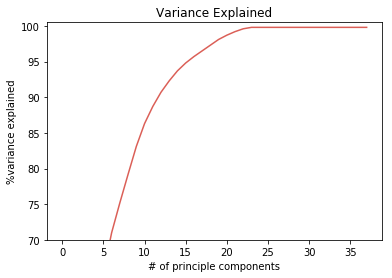

In [89]:
from sklearn.decomposition import PCA

#calculate variance explained and cumulative variance explained
covar_matrix=PCA(n_components=38)
covar_matrix.fit(x)
variance=covar_matrix.explained_variance_ratio_
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

#print graph of the variance explained with [n] features
plt.ylabel('%variance explained')
plt.xlabel('# of principle components')
plt.title('Variance Explained')
plt.ylim(70,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [107]:
#Use PCA BEFORE feeding into tSNE
pca_25=PCA(n_components=25)
pca_result_25=pca_25.fit_transform(x)
print ('Cumulative explained variance for 25 principal components:{}'.format(np.sum(pca_25.explained_variance_ratio_)))
pca_result_25

Cumulative explained variance for 25 principal components:0.9987114698816841


array([[-3.17515078e+00, -2.85457471e+00, -2.62626440e-01, ...,
         4.65755589e-02,  2.63501692e-01, -1.82332091e-01],
       [-4.59055006e+00,  1.30042193e+00,  6.47735482e-01, ...,
         3.77450456e-01, -2.38619752e-01, -2.40476569e-03],
       [-2.60769175e+00,  3.06676352e-01,  6.51122849e-01, ...,
         1.09358015e-01, -1.77289855e-01,  6.37057435e-03],
       ...,
       [ 6.77881622e-01,  1.74678806e+00, -7.43307575e-01, ...,
        -3.16964957e-01, -9.04536903e-02, -2.53479177e-01],
       [-1.20418568e+00, -2.71099079e+00, -6.10949182e-01, ...,
         5.47696488e-02,  1.16149663e-01, -2.96614851e-02],
       [ 3.54692662e+00,  1.90206098e+00, -1.63276863e+00, ...,
         2.08181621e-01,  5.71571577e-02, -3.09646161e-01]])

In [148]:
#RUNNING THE TSNE
n_sne = 5000 #with the code below, only runs the tsne on the first [n] number of values

tsne=TSNE(n_components=2, n_iter=1000, perplexity=40,random_state=123)
rndperm=np.random.permutation(new_data2.shape[0])
time_start=time.time()

#tsne_pca_results=tsne.fit_transform(pca_result_25[rndperm[:n_sne]])
tsne_pca_results=tsne.fit_transform(pca_result_25)

print ('tSNE done. Time elapsed:{} seconds'.format(time.time()-time_start))


tSNE done. Time elapsed:76.07456994056702 seconds


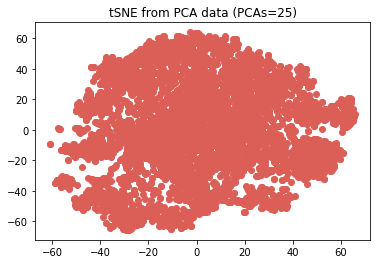

In [142]:
#PLOT tSNE results, using data from PCA 
from ggplot import *
df_tsne = None
df_tsne = new_data2.loc[rndperm[:n_sne],:].copy()

df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE from PCA data (PCAs=25)")
chart

#regular plot of tsne
plt.title('tSNE from PCA data (PCAs=25)')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1])

In [138]:
#turn PCA results from an array to a dataframe > dataframe: pca_results_25_df
pca_result_25_df=pd.DataFrame(pca_result_25)
pca_result_25_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-3.175151,-2.854575,-0.262626,0.962904,3.864523,0.574328,-0.620258,1.975108,0.728949,1.297808,...,-0.141638,-0.514680,0.271170,0.201498,-0.121300,-0.181803,0.110795,0.046576,0.263502,-0.182332
1,-4.590550,1.300422,0.647735,-0.200112,0.954340,-0.230864,0.511624,0.054346,0.375240,0.899572,...,0.657812,0.427095,0.450383,-0.254813,0.268416,0.231435,0.155784,0.377450,-0.238620,-0.002405
2,-2.607692,0.306676,0.651123,-1.440847,4.394388,-0.113349,0.817477,0.994219,1.247233,-0.512281,...,-0.419844,0.337178,0.963288,0.166252,0.001671,0.096362,-0.053332,0.109358,-0.177290,0.006371
3,-3.742633,0.071332,0.940486,-0.872892,2.818449,0.989527,-0.595013,0.439600,2.068215,1.780438,...,-0.235442,0.776597,-0.287015,1.012856,-0.557141,-0.558307,0.147031,-0.083263,-0.117207,0.040220
4,-2.082595,-0.418454,1.306395,-1.866778,3.583687,-1.271145,0.938912,1.675038,1.741492,-0.636528,...,-0.354196,-0.519699,-0.161386,0.919345,0.513603,-0.080341,0.902641,-0.122093,-0.139140,-0.014637


[5 5 3 ... 0 7 4]


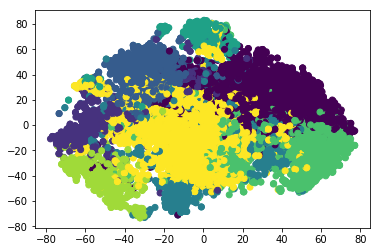

In [151]:
#for ggplot implementation see https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

#RUN KMEANS ON PCA DATA
kmeans = KMeans(n_clusters=8, random_state = 123)
kmeans.fit(pca_result_25)
print(kmeans.labels_)
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=kmeans.labels_)
